DISCLAIMER: Check "model/" folder for the complete code!

# Prerequisites

Check versions installed:

In [1]:
import flask
import requests
import sklearn
import numpy as np
import tqdm
import torch
import rich
# import seqeval # NOT INSTALLED

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('flask',flask.__version__)
print('requests',requests.__version__)
print('sklearn',sklearn.__version__)
print('numpy',np.__version__)
print('tqdm',tqdm.__version__)
print('torch',torch.__version__)
# print('rich',rich.__version__) # CANNOT BE PRINTED

flask 2.0.3
requests 2.27.1
sklearn 1.0.2
numpy 1.21.2
tqdm 4.63.0
torch 1.9.0+cu102


My imports:

In [3]:
import sys, os
from collections import Counter

import matplotlib.pyplot as plt

Important paths for the notebook:

In [4]:
homework_root_path = '../../'
data_root_path = '../../data'

data_train_path = os.path.join( data_root_path , 'train.tsv' )
data_dev_path = os.path.join( data_root_path , 'dev.tsv' )

models_classes_path = '../../model/test1/'
models_saves_path = '../../model/test1/saves/'

embedding_saves_path = '../../model/architectures/fasttext/'
train_embedding_model = False

load_model = True
train_model = False
save_model = False

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [6]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Path:

In [7]:
sys.path.append( models_classes_path )

%load_ext autoreload
%autoreload 2

# Dataset Analysis

The first thing that will be done in this first test is to see the distribution of the labels

In [8]:
def read_dataset(file_path):
    data = []
    sentence = []
    with open(file_path, "r") as data_file:
        for row in data_file:
            
            row_parts = row.rstrip().split('\t')
            
            if row_parts[0] == '#' and row_parts[1] == 'id':
                if len(sentence) > 0:
                    data.append( sentence )
                sentence = []
                continue
            
            if len(row_parts) > 1:
                sentence.append( { 'word': row_parts[0] , 'tag':  row_parts[1]} )
                
    data_file.close()
    return data

In [9]:
data_train = read_dataset(data_train_path)
data_dev = read_dataset(data_dev_path)

In [10]:
data_train[0]

[{'word': 'it', 'tag': 'O'},
 {'word': 'lies', 'tag': 'O'},
 {'word': 'approximately', 'tag': 'O'},
 {'word': 'north', 'tag': 'O'},
 {'word': 'east', 'tag': 'O'},
 {'word': 'of', 'tag': 'O'},
 {'word': 'bolesławiec', 'tag': 'B-LOC'},
 {'word': ',', 'tag': 'O'},
 {'word': 'and', 'tag': 'O'},
 {'word': 'west', 'tag': 'O'},
 {'word': 'of', 'tag': 'O'},
 {'word': 'the', 'tag': 'O'},
 {'word': 'regional', 'tag': 'O'},
 {'word': 'capital', 'tag': 'O'},
 {'word': 'wrocław', 'tag': 'B-LOC'},
 {'word': '.', 'tag': 'O'}]

In [11]:
data_dev[0]

[{'word': 'on', 'tag': 'O'},
 {'word': 'the', 'tag': 'O'},
 {'word': 'day', 'tag': 'O'},
 {'word': 'of', 'tag': 'O'},
 {'word': 'the', 'tag': 'O'},
 {'word': 'referendum', 'tag': 'O'},
 {'word': 'michael', 'tag': 'B-PER'},
 {'word': 'ashcroft', 'tag': 'I-PER'},
 {'word': 'polling', 'tag': 'O'},
 {'word': 'team', 'tag': 'O'},
 {'word': 'questioned', 'tag': 'O'},
 {'word': '12,369', 'tag': 'O'},
 {'word': 'people', 'tag': 'O'},
 {'word': 'who', 'tag': 'O'},
 {'word': 'had', 'tag': 'O'},
 {'word': 'completed', 'tag': 'O'},
 {'word': 'voting', 'tag': 'O'},
 {'word': '.', 'tag': 'O'}]

checking the distribution of the categories:

In [12]:
def get_labels_quantities(data):
    count = Counter()
    for sentence in data:
        for value in sentence:
            count[value['tag']] += 1
    return count

<BarContainer object of 13 artists>

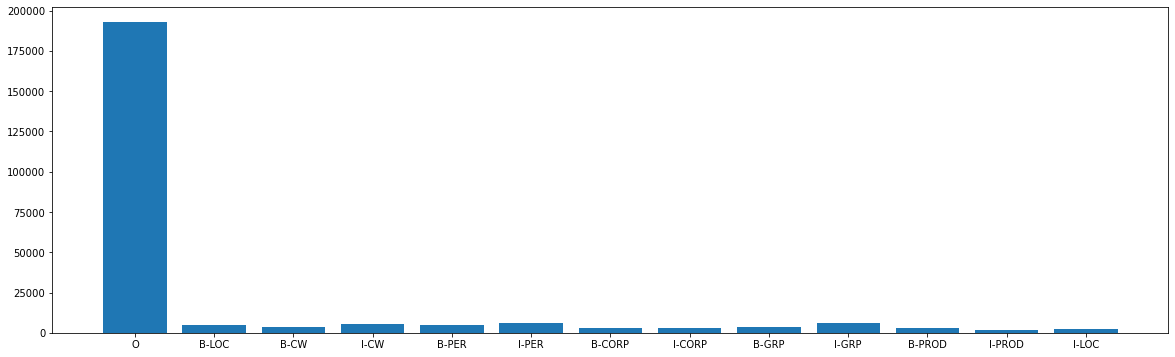

In [13]:
counts_train = get_labels_quantities(data_train)
plt.figure(figsize=(20, 6))
plt.bar(counts_train.keys(),counts_train.values(), width=0.8)

The category 'O' is predominant, but it means 'no category' to us. Let's remove it from the equation:

<BarContainer object of 12 artists>

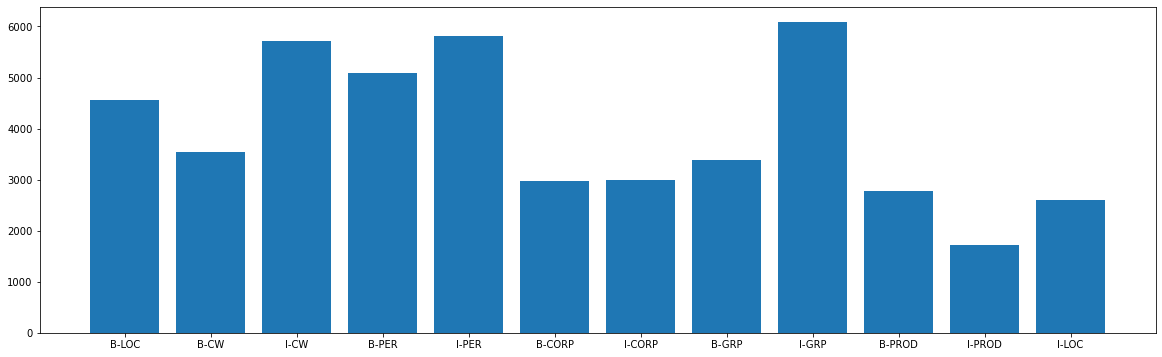

In [14]:
del counts_train['O']
plt.figure(figsize=(20, 6))
plt.bar(counts_train.keys(),counts_train.values(), width=0.8)

<BarContainer object of 12 artists>

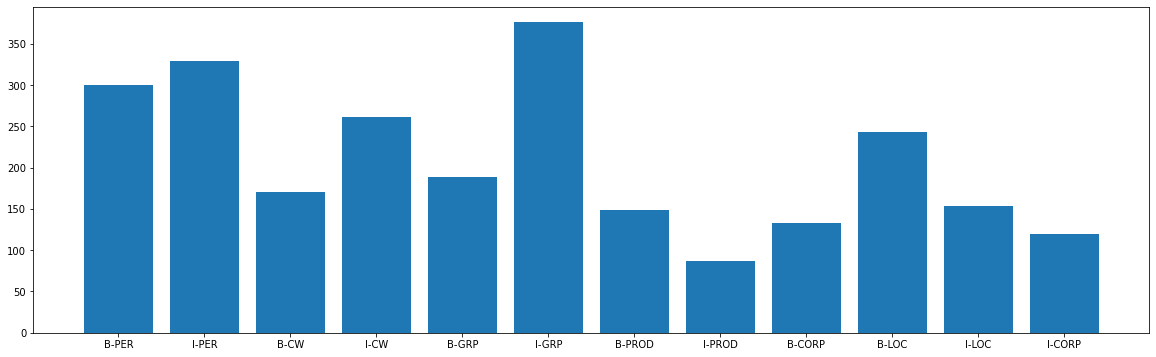

In [15]:
counts_dev = get_labels_quantities(data_dev)
del counts_dev['O']
plt.figure(figsize=(20, 6))
plt.bar(counts_dev.keys(),counts_dev.values(), width=0.8)

# Dataset Class

In [16]:
%%writefile ../../model/test1/NERDataset.py

from torch.utils.data import Dataset
import numpy as np

PAD_TOKEN = '<pad>'
window_size = 44
window_shift = window_size

class NERDataset(Dataset):
    def __init__(self, flile_path:str, window_size:int, pad_token:str, window_shift:int = -1):
        """
        Args:
            - file_path: path to the file to open
            - window_size: the maximum size of a sentence. Bigger sentences generates two or more windows
            - pad_token: the string format of the token (could be also None)
            - window_shift: the amount of shift from the last window of the same sentence to make. if it's equal to window_size then the current window starts after the end of the other
        """
        self.window_size = window_size
        self.window_shift = window_shift if window_shift > 0 else window_size
        self.pad_token = pad_token
        self.ignore_index = -1
        
        data = NERDataset.read_dataset(flile_path)
        self.create_label_mapping(data)
        windowed_data = NERDataset.generate_windows(data, self.window_size, self.window_shift, self.generate_pad_element())
        self.encoded_data = self.encode_data(windowed_data)
        
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("""Data is not encoded yet!""")
        return self.encoded_data[idx]
    
    @staticmethod
    def read_dataset(file_path:str):
        """
        Args:
            - file_path: path to the file to open \n
        Returns:
            list of lists (sentences) of dictionaries, each dictionary has: \n
                'word': a word in string format, e.g. 'hogwarts' \n
                'tag': label of the word in string format, e.g. 'O'
        """
        data = []
        sentence = []
        with open(file_path, "r") as data_file:
            for row in data_file:

                row_parts = row.rstrip().split('\t')

                if row_parts[0] == '#' and row_parts[1] == 'id':
                    if len(sentence) > 0:
                        data.append( sentence )
                    sentence = []
                    continue

                if len(row_parts) > 1:
                    sentence.append( { 'word': row_parts[0] , 'tag':  row_parts[1]} )

        data_file.close()
        return data
    
    def create_label_mapping(self, data):
        """
        Creates the mapping from label to id and from id to label \n
        Args:
            - data: the data returned by read_dataset()
        """
        labels = set()
        for sentence in data:
            for value in sentence:
                labels.add(value['tag'])
        labels = list(labels)
        labels.sort()
        self.label2id = {l:i for i,l in enumerate(labels)}
        self.id2label = labels

    def save_labels(self, path):
        np.save(path, [self.label2id, self.id2label])

    @staticmethod
    def load_labels(path):
        [label2id, id2label] = np.load(path, allow_pickle=True)
        return [label2id, id2label]
    
    @staticmethod
    def generate_windows(data, window_size, window_shift, pad_element = None):
        """
        Args:
            - data: the data returned by read_dataset()
            - window_size: the maximum size of a sentence. Bigger sentences generates two or more windows
            - window_shift: the amount of shift from the last window of the same sentence to make. if it's equal to window_size then the current window starts after the end of the other
            - pad_element: element to be put as pad (could be string, dictionary or None) \n
        Returns:
            list of lists (windows) of dictionaries, each dictionary has: \n
                'word': a word in string format, e.g. 'hogwarts' \n
                'tag': label of the word in string format, e.g. 'O'
        """
        windowed_data = []
        for sentence in data:
            windowed_sentences = [sentence[i:i+window_size] for i in range(0, len(sentence), window_shift)]
            for window in windowed_sentences:
                window = window + [pad_element]*(window_size - len(window))
                windowed_data.append(window)
            if pad_element not in windowed_data[-1]: # Adding additional None values as dummy sentence in order to determine the end of a sentence
                windowed_data.append([pad_element]*window_size)
        return windowed_data
    
    def generate_pad_element(self):
        """
        Returns:
            the pad element as a dictionary
        """
        return { 'word': self.pad_token , 'tag':  self.ignore_index} # tag is -1, to be ignored by the loss and evaluation method!!!!
    
    def encode_data(self, data):
        """
        Args:
            - data: the data returned by read_dataset() or generate_windows() \n
        Returns:
            list of dictionaries, each dictionary has: \n
                'inputs': sentence/window in list format, e.g. ['this','is',...] \n
                'outputs': labels of the sentence encoded into integers in list format, e.g. [2, 3,...] 
        """
        encoded_data = []
        for window in data:
            encoded_inputs = []
            encoded_outputs = []
            for word in window:
                encoded_inputs.append( word['word'] )
                tag = word['tag'] if word['word'] == self.pad_token else self.label2id[word['tag']]
                encoded_outputs.append( tag )
            encoded_data.append( { 'inputs':encoded_inputs , 'outputs':encoded_outputs } )
        return encoded_data

Overwriting ../../model/test1/NERDataset.py


In [17]:
from NERDataset import NERDataset, window_size, window_shift, PAD_TOKEN

# Word Embedding

The first word embedding that will be tried is FastText: the reason behind it is to remove the hassle of dealing with OOV words. The next test that will be done is to use an embedding that does not deal with OOV words (e.g. GloVe) so to use the unknown token. The implementation could be easier and also it won't have all the n-grams vocabularies (which uses lots of RAM by using it)

In [18]:
def get_sentences(data):
    sentences = []
    for data_sentence in data:
        sentences.append( [wd['word'] for wd in data_sentence] )
    return sentences

In [19]:
from gensim.models import FastText

data_train = NERDataset.read_dataset(data_train_path)
data_dev = NERDataset.read_dataset(data_dev_path)

if not train_embedding_model:
    print('Loading embedding model...')
    embedding_model = FastText.load(os.path.join(embedding_saves_path, 'embedding.model'))
else:
    print('Training embedding model...')
    # initialize the model as empty, so to train in two phases...
    embedding_model = FastText(vector_size=400, window=11, min_count=1, sg=1, hs=1, negative=0, seed=SEED)
    # add <pad> and <unk> + the vocabulary...
    supplement_sentences = get_sentences(data_train)
    supplement_sentences.insert(0, [PAD_TOKEN]) # ,'<unk>']) # FastText doesn't need it
    embedding_model.build_vocab( supplement_sentences )
    embedding_model.train(get_sentences(data_train), total_examples=embedding_model.corpus_count, epochs=embedding_model.epochs)

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Loading embedding model...


In [20]:
if train_embedding_model:
    print('Saving embedding model...')
    embedding_model.save(os.path.join(embedding_saves_path,'embedding.model'))

In [21]:
len(embedding_model.wv.key_to_index), embedding_model.vector_size

(29966, 400)

In [22]:
embedding_model.wv['affesf']

array([ 2.67738458e-02, -7.08317086e-02, -7.91705102e-02, -6.70307502e-02,
       -8.66013020e-02,  3.75388823e-02,  1.39982514e-02,  3.10069453e-02,
       -1.30810989e-02,  4.59568202e-02, -3.54561992e-02,  5.52218482e-02,
       -9.88587458e-03, -1.38216279e-02, -1.70378294e-02, -8.03057011e-03,
       -4.27361168e-02, -2.15783268e-02,  5.81846423e-02,  1.63700860e-02,
       -5.13822585e-02, -3.18123810e-02, -6.68677986e-02,  2.18897108e-02,
       -9.37767979e-03,  6.36196928e-03,  8.83736089e-02, -3.03626098e-02,
        2.26726346e-02, -1.93188444e-03,  1.81910843e-02,  1.64169632e-02,
       -1.89311728e-02,  1.36086894e-02, -2.21720710e-03, -3.61943059e-02,
        5.99874333e-02,  7.82933235e-02, -3.37397642e-02,  2.23634839e-02,
        2.87898909e-02, -3.88477370e-02, -3.59860994e-02,  4.41911444e-02,
       -9.11596939e-02, -4.57375199e-02, -7.49694370e-03,  6.07271791e-02,
       -1.12447431e-02,  3.56148891e-02,  3.78009640e-02, -3.82102132e-02,
        4.73623350e-02,  

Observing the space:

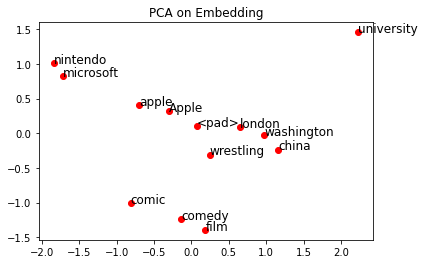

In [23]:
from sklearn.decomposition import PCA
def plot_some_data():
    # pick some words to visualise
    words = ['Apple','apple','film','washington','comedy','university','wrestling','london','china','microsoft','comic','nintendo',PAD_TOKEN]
    
    # retrieve the trained embeddings
    coords = [embedding_model.wv[word] for word in words]
    

    # perform PCA to reduce our Nd embeddings to 2d points that can be plotted
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(coords) # .t() transpose the embeddings
    
    for i,(x,y) in enumerate(pca_result):
        plt.plot(x, y, 'ro')
        plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
    plt.title('PCA on Embedding')
    plt.show()
    
plot_some_data()

In [24]:
input_size = len(embedding_model.wv.key_to_index) # how many different words?
input_length = max([len(sentence_list) for sentence_list in data_train]) # maximum length of sentence
n_labels = len(counts_train.keys())
hidden_size = 64 # to choose

print('input_size: ', input_size, '\ninput_length: ', input_length, '\nn_labels: ', n_labels, '\nhidden_size: ', hidden_size)
print()
print('dataset train samples: ', len(data_train))
print('dataset dev samples: ', len(data_dev))
print()
print('pad element:', PAD_TOKEN)
print('window size:', window_size)

input_size:  29966 
input_length:  41 
n_labels:  12 
hidden_size:  64

dataset train samples:  14534
dataset dev samples:  764

pad element: <pad>
window size: 44


# Dataset preprocessing

- Create window(s) from each sentence (e.g. window_size = window_shift = 3, None is used as \<pad\> for preprocessing here):<br>
[["this","place","is"],["very","cold","and"],["dark",None,None], ...]<br>
Do this also for the labels.
- Encode each text using the vocabulary and the label indexes<br>
Labels have also the tag -1 for padding, while the sentences have both \<pad\> and \<unk\>
- Train

In [25]:
dataset_train = NERDataset(data_train_path, window_size, PAD_TOKEN)
dataset_dev = NERDataset(data_dev_path, window_size, PAD_TOKEN)

In [26]:
dataset_train.encoded_data[0]

{'inputs': ['it',
  'lies',
  'approximately',
  'north',
  'east',
  'of',
  'bolesławiec',
  ',',
  'and',
  'west',
  'of',
  'the',
  'regional',
  'capital',
  'wrocław',
  '.',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 'outputs': [12,
  12,
  12,
  12,
  12,
  12,
  3,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  3,
  12,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1]}

In [27]:
dataset_dev.encoded_data[0]

{'inputs': ['on',
  'the',
  'day',
  'of',
  'the',
  'referendum',
  'michael',
  'ashcroft',
  'polling',
  'team',
  'questioned',
  '12,369',
  'people',
  'who',
  'had',
  'completed',
  'voting',
  '.',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 'outputs': [12,
  12,
  12,
  12,
  12,
  12,
  4,
  10,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1]}

In [28]:
dataset_train.save_labels(os.path.join(models_saves_path, 'dataset_labels.npy'))

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [29]:
dataset_train.label2id , dataset_dev.label2id

({'B-CORP': 0,
  'B-CW': 1,
  'B-GRP': 2,
  'B-LOC': 3,
  'B-PER': 4,
  'B-PROD': 5,
  'I-CORP': 6,
  'I-CW': 7,
  'I-GRP': 8,
  'I-LOC': 9,
  'I-PER': 10,
  'I-PROD': 11,
  'O': 12},
 {'B-CORP': 0,
  'B-CW': 1,
  'B-GRP': 2,
  'B-LOC': 3,
  'B-PER': 4,
  'B-PROD': 5,
  'I-CORP': 6,
  'I-CW': 7,
  'I-GRP': 8,
  'I-LOC': 9,
  'I-PER': 10,
  'I-PROD': 11,
  'O': 12})

# The Model

In [30]:
from typing import List

class Model:
    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        """
        A simple wrapper for your model

        Args:
            tokens: list of list of strings. The outer list represents the sentences, the inner one the tokens contained
            within it. Ex: [ ["This", "is", "the", "first", "homework"], ["Barack", "Obama", "was", "elected"] ]

        Returns:
            list of list of predictions associated to each token in the respective position.
            Ex: Ex: [ ["O", "O", "O", "O", "O"], ["PER", "PER", "O", "O"] ]

        """
        raise NotImplementedError

The code below will be the model that will be put in 'model/' folder.<br>
The embedding in this case is the gensim model FastText itself:

In [31]:
%%writefile ../../model/test1/NERNet.py

import torch.nn as nn
import torch
import numpy as np

from NERDataset import NERDataset, PAD_TOKEN, window_size, window_shift

class NERNet(nn.Module):
    def __init__(self, gensim_embedding, output_size, hidden_size = 128, device = 'cpu'):
        super(NERNet, self).__init__()
        
        bidirectional = True
        lstm1_layers = 2
        lstm1_dropout = 0.2 if lstm1_layers > 1 else 0
        hidden_size_classifier = hidden_size*2 if bidirectional else hidden_size
        self.device = device
        
        self.embedding = gensim_embedding.wv
        
        self.seq_encoder = nn.LSTM(
            input_size=gensim_embedding.vector_size, 
            hidden_size=hidden_size, 
            bidirectional=bidirectional, 
            num_layers=lstm1_layers, 
            dropout=lstm1_dropout
        ) 
        # self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, dropout=0.48)
        # self.dropout = nn.Dropout(0.4)
        
        self.classifier = nn.Linear(hidden_size_classifier, output_size)
        
    def forward(self, x):
        for i in range(len(x)):
            x[i] = self.embedding[x[i]]
        x = torch.tensor(x).to(self.device)
        x, (h, c) = self.seq_encoder(x)
        # x = self.dropout(x)
        x = self.classifier(x)
        return x
        
    def predict(self, tokens):
        """
        Args:
            tokens: list of list of strings. The outer list represents the sentences, the inner one the tokens contained
            within it. Ex: [ ["This", "is", "the", "first", "homework"], ["Barack", "Obama", "was", "elected"] ]
        Returns:
            list of list of predictions associated to each token in the respective position.
            Ex: Ex: [ ["O", "O", "O", "O", "O"], ["PER", "PER", "O", "O"] ]
        """
        self.eval() # dropout to 0
        self.to(self.device)

        predictions = []

        with torch.no_grad():
            for sentence in tokens:
                windowed_sentence = NERDataset.generate_windows([sentence], window_size, window_size, pad_element = PAD_TOKEN)
                inputs = np.array(windowed_sentence)
                inputs = inputs.transpose( (1,0) ).tolist()
                y_pred = self.get_indices( self(inputs) ).transpose(0,1)
                y_pred = y_pred.reshape(-1).cpu().numpy().tolist()[:len(sentence)]
                predictions.append( y_pred )
                
        return predictions

    def get_indices(self, torch_outputs):
        """
        Args:
            torch_outputs (Tensor): a Tensor with shape (batch_size, max_len, label_vocab_size) or (max_len, batch_size, label_vocab_size) containing the logits outputed by the neural network.
        Output:
            The method returns a tensor.
        """
        max_indices = torch.argmax(torch_outputs, -1) # resulting shape = (batch_size, max_len)
        return max_indices
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path, map_location=self.device))
        self.eval()
    
    def save_weights(self, path):
        torch.save(self.state_dict(), path)

Overwriting ../../model/test1/NERNet.py


In [32]:
from NERNet import NERNet

In [33]:
model = NERNet(gensim_embedding=embedding_model, output_size=len(dataset_train.id2label), device=device)

In [34]:
if load_model:
    print('Loading weights...')
    model.load_weights(os.path.join(models_saves_path, 'nernet_weights.pth'))
    print('Loaded')

Loading weights...
Loaded


# Training Phase

In [35]:
BATCH_SIZE = 32
EPOCHS = 200

Generating the Dataloader:

In [36]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_dev = DataLoader(dataset_dev, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
for x in dataloader_train:
    generic_element = x
    break
np.array(generic_element['inputs']).shape # (window_size, batch_size)

(44, 32)

Using the optimizer:

In [38]:
import torch.optim as optim

loss_function = torch.nn.CrossEntropyLoss(ignore_index=dataset_train.ignore_index) # !
optimizer = optim.SGD(model.parameters(), lr=0.0016, momentum=0.9)

This training function was taken and modified from the notebook #5:

In [52]:
def train_and_evaluate(
    model: torch.nn.Module,
    loss_function,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader = None,
    epochs: int = 5,
    verbose: bool = True,
    device = 'cpu'
):

    train_history = []
    valid_history = []
    
    model.to(device)

    for epoch in range(epochs):
        losses = []
        
        model.train()

        # batches of the training set
        for step, sample in enumerate(train_dataloader):
            inputs = sample['inputs']
            labels = torch.stack( sample['outputs'] )
            
            optimizer.zero_grad()
            predictions = model(inputs)
            
            predictions = predictions.view(-1, predictions.shape[-1]).to(device)
            
            labels = labels.view(-1).to(device) # [[1,2,3], [5,3,7]] -> [1,2,3,5,3,7]
            
            sample_loss = loss_function(predictions, labels)
            sample_loss.backward()
            optimizer.step()
            losses.append(sample_loss.item())
            

        mean_loss = sum(losses) / len(losses)
        train_history.append(mean_loss)
        
        if verbose or epoch == epochs - 1:
            print(f'  Epoch {epoch:3d} => avg_loss: {mean_loss:0.6f}')
        
        if valid_dataloader:
            valid_loss = evaluate(model, valid_dataloader, loss_function, device)
            valid_history.append(valid_loss)
            if verbose:
                print(f'    Validation avg_loss => {valid_loss:0.6f}')
                print()
                
        ''''''
    return {'train_history':train_history, 'valid_history':valid_history}

def evaluate(model, valid_dataset, loss_function, device):
    valid_loss = 0.0
    model.to(device)
    # set dropout to 0!! Needed when we are in inference mode.
    model.eval()
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs']
            labels = torch.stack( sample['outputs'] )

            predictions = model(inputs)
            predictions = predictions.view(-1, predictions.shape[-1]).to(device)
            labels = labels.view(-1).to(device)
            sample_loss = loss_function(predictions, labels)
            valid_loss += sample_loss.tolist()

    return valid_loss / len(valid_dataset)

In [38]:
if train_model:
    history = train_and_evaluate(model, loss_function, optimizer, dataloader_train, dataloader_dev, epochs=EPOCHS, verbose=True, device=device)

  Epoch   0 => avg_loss: 1.244432
    Validation avg_loss => 0.983151

  Epoch   1 => avg_loss: 0.981513
    Validation avg_loss => 0.975432

  Epoch   2 => avg_loss: 0.976420
    Validation avg_loss => 0.970761

  Epoch   3 => avg_loss: 0.971461
    Validation avg_loss => 0.967228

  Epoch   4 => avg_loss: 0.968939
    Validation avg_loss => 0.964112

  Epoch   5 => avg_loss: 0.966641
    Validation avg_loss => 0.960901

  Epoch   6 => avg_loss: 0.962516
    Validation avg_loss => 0.957320

  Epoch   7 => avg_loss: 0.957708
    Validation avg_loss => 0.953051

  Epoch   8 => avg_loss: 0.953968
    Validation avg_loss => 0.947846

  Epoch   9 => avg_loss: 0.947456
    Validation avg_loss => 0.941456

  Epoch  10 => avg_loss: 0.941052
    Validation avg_loss => 0.934092

  Epoch  11 => avg_loss: 0.933708
    Validation avg_loss => 0.926184

  Epoch  12 => avg_loss: 0.926019
    Validation avg_loss => 0.918551

  Epoch  13 => avg_loss: 0.918422
    Validation avg_loss => 0.911555

  Epoc

# Saving...

In [39]:
if save_model:
    model.save_weights(os.path.join(models_saves_path,'nernet_weights.pth'))

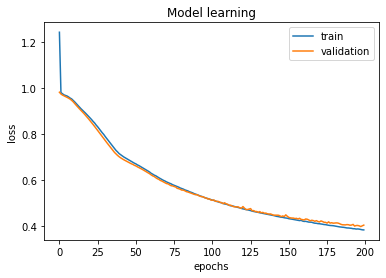

In [41]:
import matplotlib.pyplot as plt

if train_model:
    plt.plot([i for i in range(len(history['train_history']))], history['train_history'], label='train')
    plt.plot([i for i in range(len(history['valid_history']))], history['valid_history'], label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Evaluating metrics...

In [40]:
def remove_indices_from_lists(y_pred, y_true, black_list):
    '''
    Removes from y_pred and y_true the values contained in black_list that matches with y_true
    '''
    y_pred_refined, y_true_refined = [], []
    for p,l in zip(y_pred, y_true):
        if l not in black_list:
            y_pred_refined.append(p) 
            y_true_refined.append(l)
    return y_pred_refined, y_true_refined

def obtain_pred_labels(model, valid_dataset, device):
    model.to(device)
    model.eval() # dropout to 0

    y_true_total = []
    y_pred_total = []
    
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs']
            y_true = torch.stack( sample['outputs'] )

            y_pred = model(inputs)
            y_pred = model.get_indices(y_pred)
            
            y_pred_total.append(y_pred.view(-1))
            y_true_total.append(y_true.view(-1))

    y_pred, y_true = torch.cat(y_pred_total, dim=0).cpu().numpy(), torch.cat(y_true_total, dim=0).cpu().numpy()
    y_pred, y_true = remove_indices_from_lists(y_pred, y_true, [-1])
    return y_pred, y_true

In [41]:
y_pred, y_true = obtain_pred_labels(model, dataloader_dev, device)

In [263]:
from sklearn.metrics import classification_report

print( classification_report(y_true, y_pred, target_names=dataset_train.id2label) )

              precision    recall  f1-score   support

      B-CORP       0.59      0.33      0.43       133
        B-CW       0.53      0.16      0.25       170
       B-GRP       0.76      0.41      0.53       189
       B-LOC       0.67      0.56      0.61       243
       B-PER       0.73      0.71      0.72       300
      B-PROD       0.47      0.11      0.17       149
      I-CORP       0.54      0.36      0.43       119
        I-CW       0.56      0.34      0.42       261
       I-GRP       0.78      0.53      0.63       376
       I-LOC       0.60      0.49      0.54       153
       I-PER       0.75      0.74      0.74       329
      I-PROD       0.40      0.14      0.21        87
           O       0.91      0.98      0.95     10230

    accuracy                           0.88     12739
   macro avg       0.64      0.45      0.51     12739
weighted avg       0.86      0.88      0.86     12739



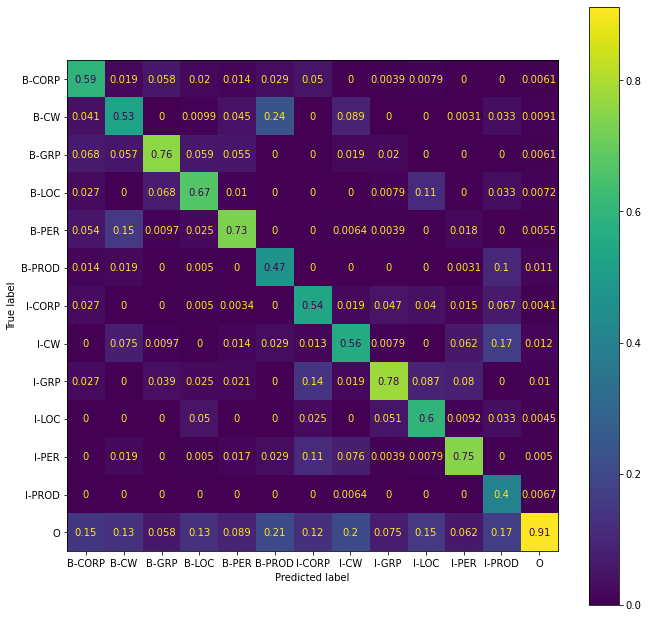

In [266]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='pred') # normalized over predicted label: the sum of each column is 1
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset_train.id2label)
fig, ax = plt.subplots(figsize=(11,11))
cmd.plot(ax=ax)

# Testing usability...

In [42]:
model.to(device)
model.eval() # dropout to 0
with torch.no_grad():
    y_true_sample = ['B-PER','I-PER','O','B-CORP','O','O','O','O','B-CORP','I-CORP','O']
    input_sample = ['John','Lucas','joined','Aiimi','as','data','scientist','in','New','York','.']
    y_pred_sample = model([input_sample])
    y_pred_sample = model.get_indices(y_pred_sample)
y_pred_sample


tensor([[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]], device='cuda:0')

In [43]:
model.predict([['John','Lucas','joined','Aiimi','as','data','scientist','in','New','York','.']])

[[4, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12]]

In [46]:
class StudentModel(Model):

    # STUDENT: construct here your model
    # this class should be loading your weights and vocabulary
    def __init__(self):
        #print('Creating student...')
        [self.label2id, self.id2label] = NERDataset.load_labels('../../model/test1/saves/dataset_labels.npy')
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #print('Creating model...')
        self.model = NERNet( FastText.load('../../model/architectures/fasttext/embedding.model') , output_size=len(self.id2label) , device=device)
        #print('Loading model...')
        self.model.load_weights('../../model/test1/saves/nernet_weights.pth')
        #print('Init done')

    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        # STUDENT: implement here your predict function
        # remember to respect the same order of tokens!
        #print('Predicting...')
        predictions = self.model.predict(tokens)
        for i in range(len(predictions)):
           for j in range(len(predictions[i])):
               predictions[i][j] = self.id2label[predictions[i][j]]
        return predictions

In [47]:
student = StudentModel()

Creating student...
Creating model...
Loading model...
Init done


In [48]:
data_eval_input = []
data_eval_label = []
for sentence in data_dev:
    data_eval_input.append([w['word'] for w in sentence])
    data_eval_label.append([w['tag'] for w in sentence])

In [49]:
data_eval_predict = student.predict(data_eval_input)

Predicting...


In [50]:
from seqeval.metrics import accuracy_score, f1_score

acc = accuracy_score(data_eval_label, data_eval_predict)
f = f1_score(data_eval_label, data_eval_predict, average="macro")

print(f"# accuracy: {acc:.4f}")
print(f"# f1: {f:.4f}")

# accuracy: 0.8804
# f1: 0.3764


FastText consumes a lot of RAM, another approach must be found. More tests are needed in order to determine the best embedding. The next test will be focusing on GloVe